### Importações

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler


from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    RocCurveDisplay,
    fbeta_score,
    make_scorer
)

import matplotlib.pyplot as plt
import os

### Carregar Dataset

In [ ]:
datasets = {
    "Base": pd.read_csv('CardiopatiaModel/Data/risco_cardiovascular_base.csv'),
    "Features": pd.read_csv('CardiopatiaModel/Data/risco_cardiovascular_features.csv')
}

In [ ]:
datasets["Base"].head()

,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,BP_Category,HighRisk
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,No Disorder,Normal,0
1,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,No Disorder,Normal,0
2,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,No Disorder,Normal,0
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,Hypertension_Stage1,1
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,Hypertension_Stage1,1


In [ ]:
datasets["Features"].head()


,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Heart Rate,Daily Steps,Sleep Disorder,BP_Category,HighRisk,Sleep_Efficiency,Cardiac_Stress_Index
0,Male,27,Software Engineer,6.1,6,42,6,Overweight,77,4200,No Disorder,Normal,0,36.6,462
1,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,No Disorder,Normal,0,37.2,600
2,Male,28,Doctor,6.2,6,60,8,Normal Weight,75,10000,No Disorder,Normal,0,37.2,600
3,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,Hypertension_Stage1,1,23.6,680
4,Male,28,Sales Representative,5.9,4,30,8,Obese,85,3000,Sleep Apnea,Hypertension_Stage1,1,23.6,680


### Parâmetros

In [ ]:
resampler = [
    SMOTE(random_state=42),
    RandomOverSampler(random_state=42),
    RandomUnderSampler(random_state=42),
    "passthrough"
]

models_config = {
    "SVM_linear": {
        "model": SVC(
            kernel="linear",
            class_weight="balanced",        # ajuda quando NÃO usar resampler
            probability=True,               # para AUC/curvas
            decision_function_shape="ovr",
            random_state=42
        ),
        "params": {
            "resampler": resampler,
            "pca": ["passthrough", PCA(n_components=0.95, random_state=42)],
            "classifier__C": [0.1, 1, 10, 100],
            "classifier__class_weight": [None, "balanced"]
        }
    },

    "SVM_rbf": {
        "model": SVC(
            kernel="rbf",
            probability=True,
            decision_function_shape="ovr",
            random_state=42
        ),
        "params": {
            "resampler": resampler,
            "pca": ["passthrough", PCA(n_components=0.95, random_state=42)],
            "classifier__C": [0.1, 1, 10, 100],
            "classifier__gamma": ["scale", "auto", 0.01, 0.1, 1],
            "classifier__class_weight": [None, "balanced"]
        }
    }
}

### Loop de Treinamento

In [ ]:
import os, joblib
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.metrics import f1_score, accuracy_score, fbeta_score, make_scorer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# Pasta para salvar modelos
output_path = "CardiopatiaModel/"
model_save_path = os.path.join(output_path, "models")
os.makedirs(model_save_path, exist_ok=True)

results_list = []

for ds_name, df in datasets.items():
    print(f"\n>>> Processando Dataset: {ds_name}")

    # Target multiclasses
    y = df["BP_Category"]
    X = df.drop(columns=["BP_Category"], errors="ignore")

    bmi_order = ["Underweight", "Normal Weight", "Overweight", "Obese"]
    bmi_col = ["BMI Category"]

    cat_cols = [c for c in X.select_dtypes(include=['object']).columns if c != "BMI Category"]
    num_cols = X.select_dtypes(exclude=['object']).columns.tolist()

    preprocessor = ColumnTransformer(transformers=[
        ('ordinal', OrdinalEncoder(categories=[bmi_order]), bmi_col),
        ('numeric', StandardScaler(), num_cols),
        ('categories', OneHotEncoder(handle_unknown='ignore'), cat_cols)
    ])

    # Split treino/teste
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # CV (10 folds)
    cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    # Scorer
    f2_weighted = make_scorer(fbeta_score, beta=2, average="weighted")

    for model_name, config in models_config.items():
        print(f"\n--- Iniciando GridSearch para {model_name} (SVM) ---")


        pipeline = ImbPipeline(steps=[
            ("preprocessor", preprocessor),
            ("resampler", SMOTE(random_state=42)),   # placeholder: será substituído pelo grid (inclui passthrough)
            ("pca", "passthrough"),                  # placeholder: será substituído pelo grid
            ("classifier", config["model"]),
        ])

        grid = GridSearchCV(
            pipeline,
            config["params"],
            cv=cv,
            scoring={"f1_macro": "f1_macro", "accuracy": "accuracy", "f2_weighted": f2_weighted},
            refit="f1_macro",
            n_jobs=-1,
            verbose=1
        )

        grid.fit(X_train, y_train)

        cv_res = pd.DataFrame(grid.cv_results_)
        best_idx = grid.best_index_

        # Métricas de validação (CV) do melhor modelo
        val_f1 = grid.best_score_
        val_acc = cv_res.loc[best_idx, "mean_test_accuracy"]
        val_f2 = cv_res.loc[best_idx, "mean_test_f2_weighted"]

        # Métricas no teste
        y_pred = grid.predict(X_test)
        test_f1 = f1_score(y_test, y_pred, average="macro")
        test_acc = accuracy_score(y_test, y_pred)
        test_f2 = fbeta_score(y_test, y_pred, beta=2, average="weighted")

        # Salvar o melhor modelo
        model_filename = f"{model_name}_{ds_name}.pkl"
        joblib.dump(grid.best_estimator_, os.path.join(model_save_path, model_filename))

        results_list.append({
            "Model": model_name,
            "Dataset": ds_name,
            "Best_Params": str(grid.best_params_),
            "Val_F1_Macro": val_f1,
            "Val_F2_Weighted": val_f2,
            "Val_Accuracy": val_acc,
            "Test_F1_Macro": test_f1,
            "Test_F2_Weighted": test_f2,
            "Test_Accuracy": test_acc,
        })

# Resultados finais
results_df = pd.DataFrame(results_list).sort_values(by="Val_F1_Macro", ascending=False)
display(results_df)



>>> Processando Dataset: Base

--- Iniciando GridSearch para SVM_linear (SVM) ---
Fitting 10 folds for each of 64 candidates, totalling 640 fits

--- Iniciando GridSearch para SVM_rbf (SVM) ---
Fitting 10 folds for each of 320 candidates, totalling 3200 fits

>>> Processando Dataset: Features

--- Iniciando GridSearch para SVM_linear (SVM) ---
Fitting 10 folds for each of 64 candidates, totalling 640 fits

--- Iniciando GridSearch para SVM_rbf (SVM) ---
Fitting 10 folds for each of 320 candidates, totalling 3200 fits


,Model,Dataset,Best_Params,Val_F1_Macro,Val_F2_Weighted,Val_Accuracy,Test_F1_Macro,Test_F2_Weighted,Test_Accuracy
1,SVM_rbf,Base,"{'classifier__C': 100, 'classifier__class_weig...",0.983585,0.983008,0.983218,0.987464,0.986626,0.986667
3,SVM_rbf,Features,"{'classifier__C': 10, 'classifier__class_weigh...",0.980433,0.979706,0.979885,0.938664,0.932246,0.933333
0,SVM_linear,Base,"{'classifier__C': 1, 'classifier__class_weight...",0.977093,0.976203,0.976552,0.924131,0.919053,0.920000
2,SVM_linear,Features,"{'classifier__C': 1, 'classifier__class_weight...",0.973291,0.972843,0.973218,0.924131,0.919053,0.920000


### Resultados e Avaliação

In [ ]:
pd.set_option("display.max_colwidth", None)

df_results = pd.DataFrame(results_list)

for model_name in models_config.keys():
    df_model = df_results[df_results["Model"] == model_name].copy()

    filename = f"resultado_final_{model_name}.csv"
    df_model.to_csv(os.path.join(output_path, filename), index=False)

    print(f"\n--- Tabela Final: {model_name} ---")
    display(df_model[
        ["Dataset",
         "Val_F1_Macro", "Val_F2_Weighted", "Val_Accuracy",
         "Test_F1_Macro", "Test_F2_Weighted", "Test_Accuracy",
         "Best_Params"]
    ])

print(f"\nProcesso concluído! Os arquivos foram salvos em: {output_path}")


--- Tabela Final: SVM_linear ---


,Dataset,Val_F1_Macro,Val_F2_Weighted,Val_Accuracy,Test_F1_Macro,Test_F2_Weighted,Test_Accuracy,Best_Params
0,Base,0.977093,0.976203,0.976552,0.924131,0.919053,0.92,"{'classifier__C': 1, 'classifier__class_weight': None, 'pca': 'passthrough', 'resampler': SMOTE(random_state=42)}"
2,Features,0.973291,0.972843,0.973218,0.924131,0.919053,0.92,"{'classifier__C': 1, 'classifier__class_weight': None, 'pca': 'passthrough', 'resampler': SMOTE(random_state=42)}"



--- Tabela Final: SVM_rbf ---


,Dataset,Val_F1_Macro,Val_F2_Weighted,Val_Accuracy,Test_F1_Macro,Test_F2_Weighted,Test_Accuracy,Best_Params
1,Base,0.983585,0.983008,0.983218,0.987464,0.986626,0.986667,"{'classifier__C': 100, 'classifier__class_weight': None, 'classifier__gamma': 0.01, 'pca': 'passthrough', 'resampler': SMOTE(random_state=42)}"
3,Features,0.980433,0.979706,0.979885,0.938664,0.932246,0.933333,"{'classifier__C': 10, 'classifier__class_weight': None, 'classifier__gamma': 0.01, 'pca': 'passthrough', 'resampler': SMOTE(random_state=42)}"



Processo concluído! Os arquivos foram salvos em: /content/drive/MyDrive/Ps Ligia Time 16


In [ ]:
best_model_path = os.path.join(model_save_path, "SVM_rbf_Base.pkl")
best_model = joblib.load(best_model_path)

print("Carregado:", best_model_path)
print(best_model)

Carregado: /content/drive/MyDrive/Ps Ligia Time 16/models/SVM_rbf_Base.pkl
Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('ordinal',
                                                  OrdinalEncoder(categories=[['Underweight',
                                                                              'Normal '
                                                                              'Weight',
                                                                              'Overweight',
                                                                              'Obese']]),
                                                  ['BMI Category']),
                                                 ('numeric', StandardScaler(),
                                                  ['Age', 'Sleep Duration',
                                                   'Quality of Sleep',
                                                   'Physical Activity Level',
       

In [ ]:
df_base = datasets["Base"].copy()
X = df_base.drop(columns=["BP_Category"], errors="ignore")
y = df_base["BP_Category"]

X = X.drop(columns=["HighRisk"], errors="ignore")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


### Classification Report

In [ ]:
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))


                     precision    recall  f1-score   support

           Elevated     0.9565    1.0000    0.9778        22
Hypertension_Stage1     1.0000    1.0000    1.0000        20
             Normal     1.0000    0.9697    0.9846        33

           accuracy                         0.9867        75
          macro avg     0.9855    0.9899    0.9875        75
       weighted avg     0.9872    0.9867    0.9867        75



### Matriz de Confusão

<Figure size 600x500 with 0 Axes>

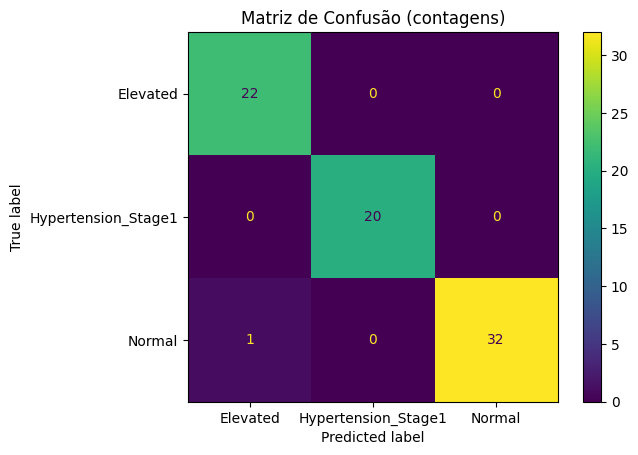

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

labels = sorted(y_test.unique())

cm = confusion_matrix(y_test, y_pred, labels=labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

plt.figure(figsize=(6, 5))
disp.plot(values_format="d")
plt.title("Matriz de Confusão (contagens)")
plt.show()


### Métricas resumidas

In [ ]:
from sklearn.metrics import f1_score, fbeta_score, accuracy_score

acc = accuracy_score(y_test, y_pred)
f1_macro = f1_score(y_test, y_pred, average="macro")
f2_weighted = fbeta_score(y_test, y_pred, beta=2, average="weighted")

print(f"Accuracy     : {acc:.4f}")
print(f"F1 Macro     : {f1_macro:.4f}")
print(f"F2 Weighted  : {f2_weighted:.4f}")


Accuracy     : 0.9867
F1 Macro     : 0.9875
F2 Weighted  : 0.9866


### ROC-AU

In [ ]:
from sklearn.metrics import roc_auc_score

y_proba = best_model.predict_proba(X_test)

auc_ovr_weighted = roc_auc_score(y_test, y_proba, multi_class="ovr", average="weighted")
auc_ovr_macro = roc_auc_score(y_test, y_proba, multi_class="ovr", average="macro")

print(f"AUC-ROC OvR (weighted): {auc_ovr_weighted:.4f}")
print(f"AUC-ROC OvR (macro)   : {auc_ovr_macro:.4f}")


AUC-ROC OvR (weighted): 1.0000
AUC-ROC OvR (macro)   : 1.0000
